## The structure of hippocampal CA1 interactions optimizes spatial coding across experience
Michele Nardin, Jozsef Csicsvari, Gašper Tkačik, Cristina Savin

https://doi.org/10.1101/2021.09.28.460602

Correlations among pairs of hippocampal neurons arise as a result of two effects: mechanisms that give rise to spatial tuning (i.e.\ *signal* correlations), and tuning-independent internal circuit dynamics (which shape *noise* correlations). 


Unlike sensory areas, where stimulus repeats make the estimation of noise correlations relatively straightforward, measuring circuit interactions  and their contribution to spatial coding in the hippocampus is fraught with technical difficulties. 


Since the animals are freely moving in a two dimensional environment, the lack of stimulus repeats renders traditional approaches for estimating noise correlations inapplicable. Moreover, well documented circuit level oscillations act as global sources of co-modulation that obscure the fine structure of pairwise neural co-variability.

The key challenge is to partition total neural covariability into an explainable component, driven by position, oscillations and other global signals (measured by spike synchrony) and unexplained, or ``excess'' correlations, which capture local interactions. 

**Here we take advantage of the maximum entropy framework to develop a new statistical test for detecting excess correlations in the absence of stimulus repeats**

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stat
import numpy as np
import scipy.io

## Inference of excess correlations

#### Rationale

We construct a null model for population responses $(y_1, \dots, y_N)$ that takes into account the position of the animal, $\mathbf{x}$ and the population synchrony, $k = \sum_i^N{y_i}$, but is otherwise maximally variable. We use this model to generate a large ensemble of surrogate datasets, that match the data with respect to tuning but without additional noise correlations. Using these surrogates allow us to estimate an empirical distribution of (total) pairwise correlations under the null model, which we then compare to data.

#### Method

Under the assumption that spike counts have mean $\lambda(\mathbf{s},k)$ with Poisson noise, the distribution of the joint neural responses under the null model factorizes as:
\begin{equation}\label{cond_indep_model}
p_{ind}(y \, \big| s, K) = \prod \mathrm{Poisson}(y_i | \lambda_i(\mathbf{s},k)).
\end{equation}
One important caveat is that the population synchrony depends on the neural responses themselves, which introduces the additional constraint that $k = \sum_i{y_i}$ for each of these surrogate draws, something that we enforce by rejection sampling.

#### Inference of  null model parameters

To estimate the tuning function of each cell,  $\lambda_i(\mathbf{s},k)$, we use a nonparametric approach based on Gaussian Process priors. See details in "Estimating nonlinear neural response functions using GP priors and Kronecker methods" Savin, Tkacik, NeurIPS 2016.
The code used for our analysis is released in this GitHub repository and called "Cells_3D_Tuning.m".

In [2]:
# load MAT file containing the 3D place fields inferred using the script "Cells_3D_Tuning.m"
mat = scipy.io.loadmat('data/PFGP3D_N50.mat',squeeze_me=True)['pfs']
# this is a 5 dimensonal array, and it contains place fields for: 
# - 50 cells
# - mean and STD in log-firing
# - tuning for x,y,k (20 X 20 X 10)

In [5]:
# number of neurons
N = mat.shape[0]

In [6]:
# load "real" synthetic data (i.e. simulated with script Synthetic_Data.ipynb)
x = np.loadtxt('x_Ising_Osc_50')
y = np.loadtxt('y_Ising_Osc_50_C')

In [7]:
# count the number of coactive cells
k = np.sum(y,1)

In [8]:
# bin behavior (20 X 20 equally spaced bins)
B=20
bin_pos=stat.binned_statistic_2d(x.T[0],x.T[1],values=np.ones_like(x.T[0]),statistic='count',
                                     bins=np.arange(B+1)/B,expand_binnumbers=True)[3].T-1

# bin synchrony (i.e. K) into 10 equally populated bins
edges = [np.percentile(k,i*10) for i in range(11)]
bin_syn=stat.binned_statistic(k,values=np.ones_like(k),statistic='count',bins=edges)[2]-1

#### Generating surrogate data --- 1
At each moment in time, given the position $\mathbf{x}$ and population synchrony $k$, the GP tuning estimate provides a distribution over possible firing rates for cell $i$, $\lambda_i(\mathbf{s},k)$, as a log normal distribution, $\log \lambda_i \sim \mathcal{N}(\mu_{f_*}, \sigma_{f_*})$. This captures uncertainty about the tuning of the cell, given the data. Our method allows us to propagate this uncertainty throughout all the subsequent analyses by sampling firing rates from this distribution (formally, by treating neural responses as arising from a doubly stochastic point model).  

In [9]:
# mean inferred log firing
mea = np.array([mat[:,0,b[0],b[1],bin_syn[ib]] for ib,b in enumerate(bin_pos)])
# std of inferred log firing
std = np.sqrt(np.array([mat[:,1,b[0],b[1],bin_syn[ib]] for ib,b in enumerate(bin_pos)]))

#### Generating surrogate data --- 2
We generate surrogate spike counts in two steps. First, we sample the mean firing from this $p(\lambda_i|s,K)$ distribution. Second, for each $\lambda_i$ sample, we draw the corresponding spike count from $\mathrm{Poisson}(\lambda_i)$. Applying this procedure for all cells and all time points generates a surrogate dataset from the unconstrained null model. We enforce the constraint $\sum_i y_i = k$ by discarding and redrawing samples that do not satisfy it. In rare cases (less than $2\%$ of data), it was not possible to replicate the desired $k$ statistic, i.e. achieving the desires $k$ required more than $500$ re-samplings. Such time bins were excluded from subsequent analysis (both for for real data and all surrogates). 
We generate a total of $1000$ surrogate datasets.

In [11]:
# number of surrogate datasets
n_sim=1000
# max number of re-samplings
maxiter=500

# save both the firing (yfks) and the number of rejections (cnts)
yfks = np.zeros([n_sim, len(k), N])
cnts = np.zeros([n_sim, len(k)])

In [12]:
# rejection sampling routine
def rej_samp(fr, k, maxiter):
    # simulate Poisson
    yfake = np.zeros_like(fr)
    count = np.zeros(len(k))
    for ifir, fir in enumerate(fr): # for each time step
        temp = np.random.poisson(fir)>0
        c = 0
        while np.sum(temp)!=k[ifir] and c < maxiter: # if k statistic doesn't match - resample
            temp = np.random.poisson(fir)>0
            c+=1
        count[ifir] = c
        yfake[ifir] = temp
    return yfake, count

In [21]:
# simulate use rejection sampling: whenever the number of neurons active is not the same, reject and resample
for i in range(n_sim):
    if np.mod(i,10)==0:
        print('*',end='')
    ## sample posterior
    post = mea + np.random.randn(std.shape[0],std.shape[1])*std
    ## turn into firing rate
    fr = np.exp(post)
    ## rejection sampling
    yfake, count = rej_samp(fr,k,maxiter)
    ## save firing and counts
    yfks[i] = yfake
    cnts[i] = count

**********

In [22]:
# check for problematic samples (i.e. 500 resamples) - mark them so to exclude from subsequent analysis
max_counts = np.max(cnts,0)

# print proportion of samples excluded
print(np.mean(max_counts >= maxiter-1))

0.014942980731419583


### Inference of excess correlations

#### Rationale
We use the pairwise correlations between neural responses as the test statistic and compare it to the distribution of pairwise correlations expected under the null model that assumes that the firing rate of cells is only driven by the stimulus and the synchrony of the population, without further pairwise interactions. 

#### Method
Given the Pearson correlation coefficient between the activities of cells $i$ and $j$ computed on real data, $c_{ij}$, and $c_{ij}^\gamma$ the same quantity computed on a surrogate dataset $\{\mathbf{y}^\gamma_{1:t}\}$ for $\gamma = 1,2,\dots 1000$.
We define the quantity we refer to as ``excess correlations'' as:
\begin{equation}
w_{ij} = \frac{c_{ij} - <c_{ij}^\gamma>}{\sigma(c_{ij}^\gamma)}
\end{equation}
where $<\cdot>$ denotes the sample average and $\sigma$ the sample standard deviation of $c_{ij}^\gamma$. Assuming that the $c_{ij}^\gamma$ distribution is normal, this quantity is closely related to confidence bounds, and p-values (via the error function). An excess correlation is deemed significant if $|w_{ij}|>4.5$, which corresponds to a p-value threshold of $p=0.05$ with a Bonferroni correction for the $7500$ multiple comparisons.

In [23]:
# compute correlations on sampled data
fkcors = np.zeros([n_sim,N,N])
for i in range(n_sim):
    fkcors[i] = np.corrcoef(yfks[i,max_counts<maxiter-1].T)

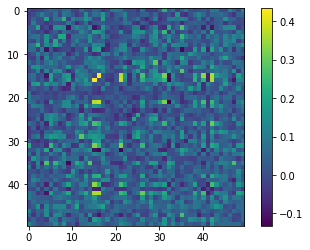

In [24]:
# compute real correlation on data
real = np.corrcoef(y[max_counts<maxiter-1].T)
plt.imshow(real - np.eye(N))
plt.colorbar()
plt.show()

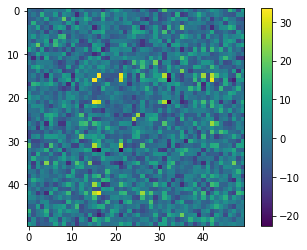

In [25]:
# compute noise correlations - simply subtract mean and divide by standard deviation
noise_corr = (real - np.mean(fkcors,0)) / np.std(fkcors,0)
plt.imshow(noise_corr)
plt.colorbar()
plt.show()

#### Check the goodness of the excesss correlations, and compare to standard correlations

In [26]:
# Ground truth connections C_ran - as simulated in Synthetic_Data.ipynb
np.random.seed(12)
C_ran = np.random.randn(N,N)
# make it symmetric
C_ran = (C_ran + C_ran.T) / 5
C_ran[np.diag_indices(N)]=0

Text(0, 0.5, 'ground truth')

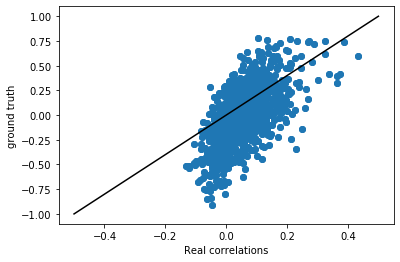

In [37]:
# scatter plot correlations vs ground truth
plt.scatter(real - np.eye(N), C_ran)
plt.plot([-0.5,0.5],[-1,1],color='k')
plt.xlabel('Real correlations')
plt.ylabel('ground truth')
# plt.xlim([-24,24])

(-24, 24)

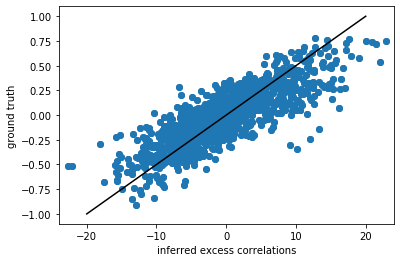

In [32]:
# scatter plot real vs inferred interactions
# notice that scale is not the same - and we do not expect that! 
# --> Inferred noise correlations are Z-values!

plt.scatter(noise_corr, C_ran)
plt.plot([-20,20],[-1,1],color='k')
plt.xlabel('inferred excess correlations')
plt.ylabel('ground truth')
plt.xlim([-24,24])

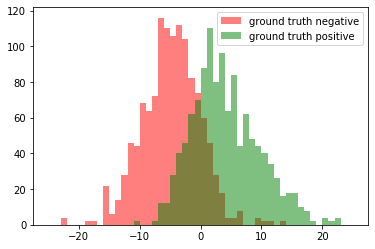

In [33]:
# histogram negative vs positive part

plt.hist(noise_corr[C_ran < 0.],np.arange(-25,26),color='red',alpha=0.5,label='ground truth negative')
plt.hist(noise_corr[C_ran > 0.],np.arange(-25,26),color='green',alpha=0.5,label='ground truth positive')
plt.legend()
plt.show()